In [1]:
import requests
import random
import pickle 
import spacy
import string
from bs4 import BeautifulSoup
from urllib.request import urlopen
from collections import Counter 
from wordcloud import WordCloud
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm.models import KneserNeyInterpolated

In [2]:
def get_links(url):

    response = requests.get(url=url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Get all the links
    all_urls = soup.find(id="bodyContent").find_all("a")
    all_wiki_links = []
    
    # Remove links to articles that don't have any/much body text
    bad_keys = ['File:', 'Special', 'Template:', 'index.php', 'action=']

    for link in all_urls:
        try:
            if link['href'].find("/wiki/") == -1: 
                continue
            elif 'File:' in link['href']:
                continue
            elif 'Special' in link['href']:
                continue
            elif 'Template:' in link['href']:
                continue
            elif 'index.php' in link['href']:
                continue
            elif 'action=' in link['href']:
                continue
            elif '#' in link['href']:
                continue

            linkToScrape = link
            full_url = "https://en.wikipedia.org" + linkToScrape['href']
            all_wiki_links.append(full_url)
        except:
            continue

    all_wiki_links.append(url)

    all_wiki_links = list(set(all_wiki_links)) 

    return all_wiki_links

def get_article_text(url):
    # Gets the article text from the specified url
    try:
        source = urlopen(url).read()
        soup = BeautifulSoup(source,'lxml')


        article_text = ''
        soup = BeautifulSoup(source,'lxml')

        for paragraph in soup.select('p'):
            article_text += paragraph.text

    except:
        article_text = ''

    return article_text

def get_all_text(main_url):
    # Scrapes text from main_url and all Wikipedia pages linked from main_url
    all_text = []
    all_wiki_links = get_links(main_url)
    print(len(all_wiki_links))

    for link in all_wiki_links:
        all_text.append(get_article_text(link))
    
    # Save to pickle file
    pickle.dump(all_text, open("wikipedia_text.p", "wb"))

def preprocess_text(text, remove_punct=True):
    # Proprocesses text by sentence splitting, tokenizing, lemmatizing, lower casing, and removing stop words
    
    all_words = []
    
    lemmatizer = WordNetLemmatizer() 
    
    sp = spacy.load("en_core_web_sm")

    all_stopwords = sp.Defaults.stop_words
    punct_list = []

    for punct in string.punctuation:
        punct_list.append(punct)
    
    punct_list += ['``', "''"]
    
    for article in text:
        if article.find("parser") == -1:
            article = article.replace("\n", "")
            sent_split = nltk.tokenize.sent_tokenize(article)
            for sentence in sent_split:
                words = nltk.tokenize.word_tokenize(sentence)
                for word in words:
                    if word.lower() not in all_stopwords:
                        if remove_punct:
                            if word not in punct_list:
                                word = lemmatizer.lemmatize(word).lower()
                                all_words.append(word)
                                
                        else:
                            word = lemmatizer.lemmatize(word).lower()
                            all_words.append(word)
        else:
            continue
    
    
    vocabulary = spacy.vocab.Vocab(all_words)
    return vocabulary, all_words
    

In [3]:
# get_all_text("https://en.wikipedia.org/wiki/COVID-19_pandemic")

In [4]:
# Loads in text I pre-saved to avoid repeatedly running get_all_text()

all_text = pickle.load( open( "wikipedia_text.p", "rb" ) )
url = "https://en.wikipedia.org/wiki/COVID-19_pandemic"

In [5]:
vocabulary, all_words = preprocess_text(all_text)

## 5.1a

In [6]:
# Get's most common words

wiki_word_count = Counter(all_words) 
most_occur = wiki_word_count.most_common(20) 

print("The 20 most common words are: ")

for pair in most_occur:
    print("%s: %s"%(pair[0], pair[1]))


The 20 most common words are: 
case: 26285
new: 14943
march: 13125
covid-19: 13035
2020: 12287
health: 11831
state: 11470
people: 11127
confirmed: 10509
government: 10287
day: 9498
number: 9472
death: 9155
announced: 9074
april: 8581
country: 8572
reported: 8428
pandemic: 7598
total: 7567
city: 7133


I feel like I would definitely know what the text was about based on these words

## 5.1b

(-0.5, 2999.5, 1999.5, -0.5)

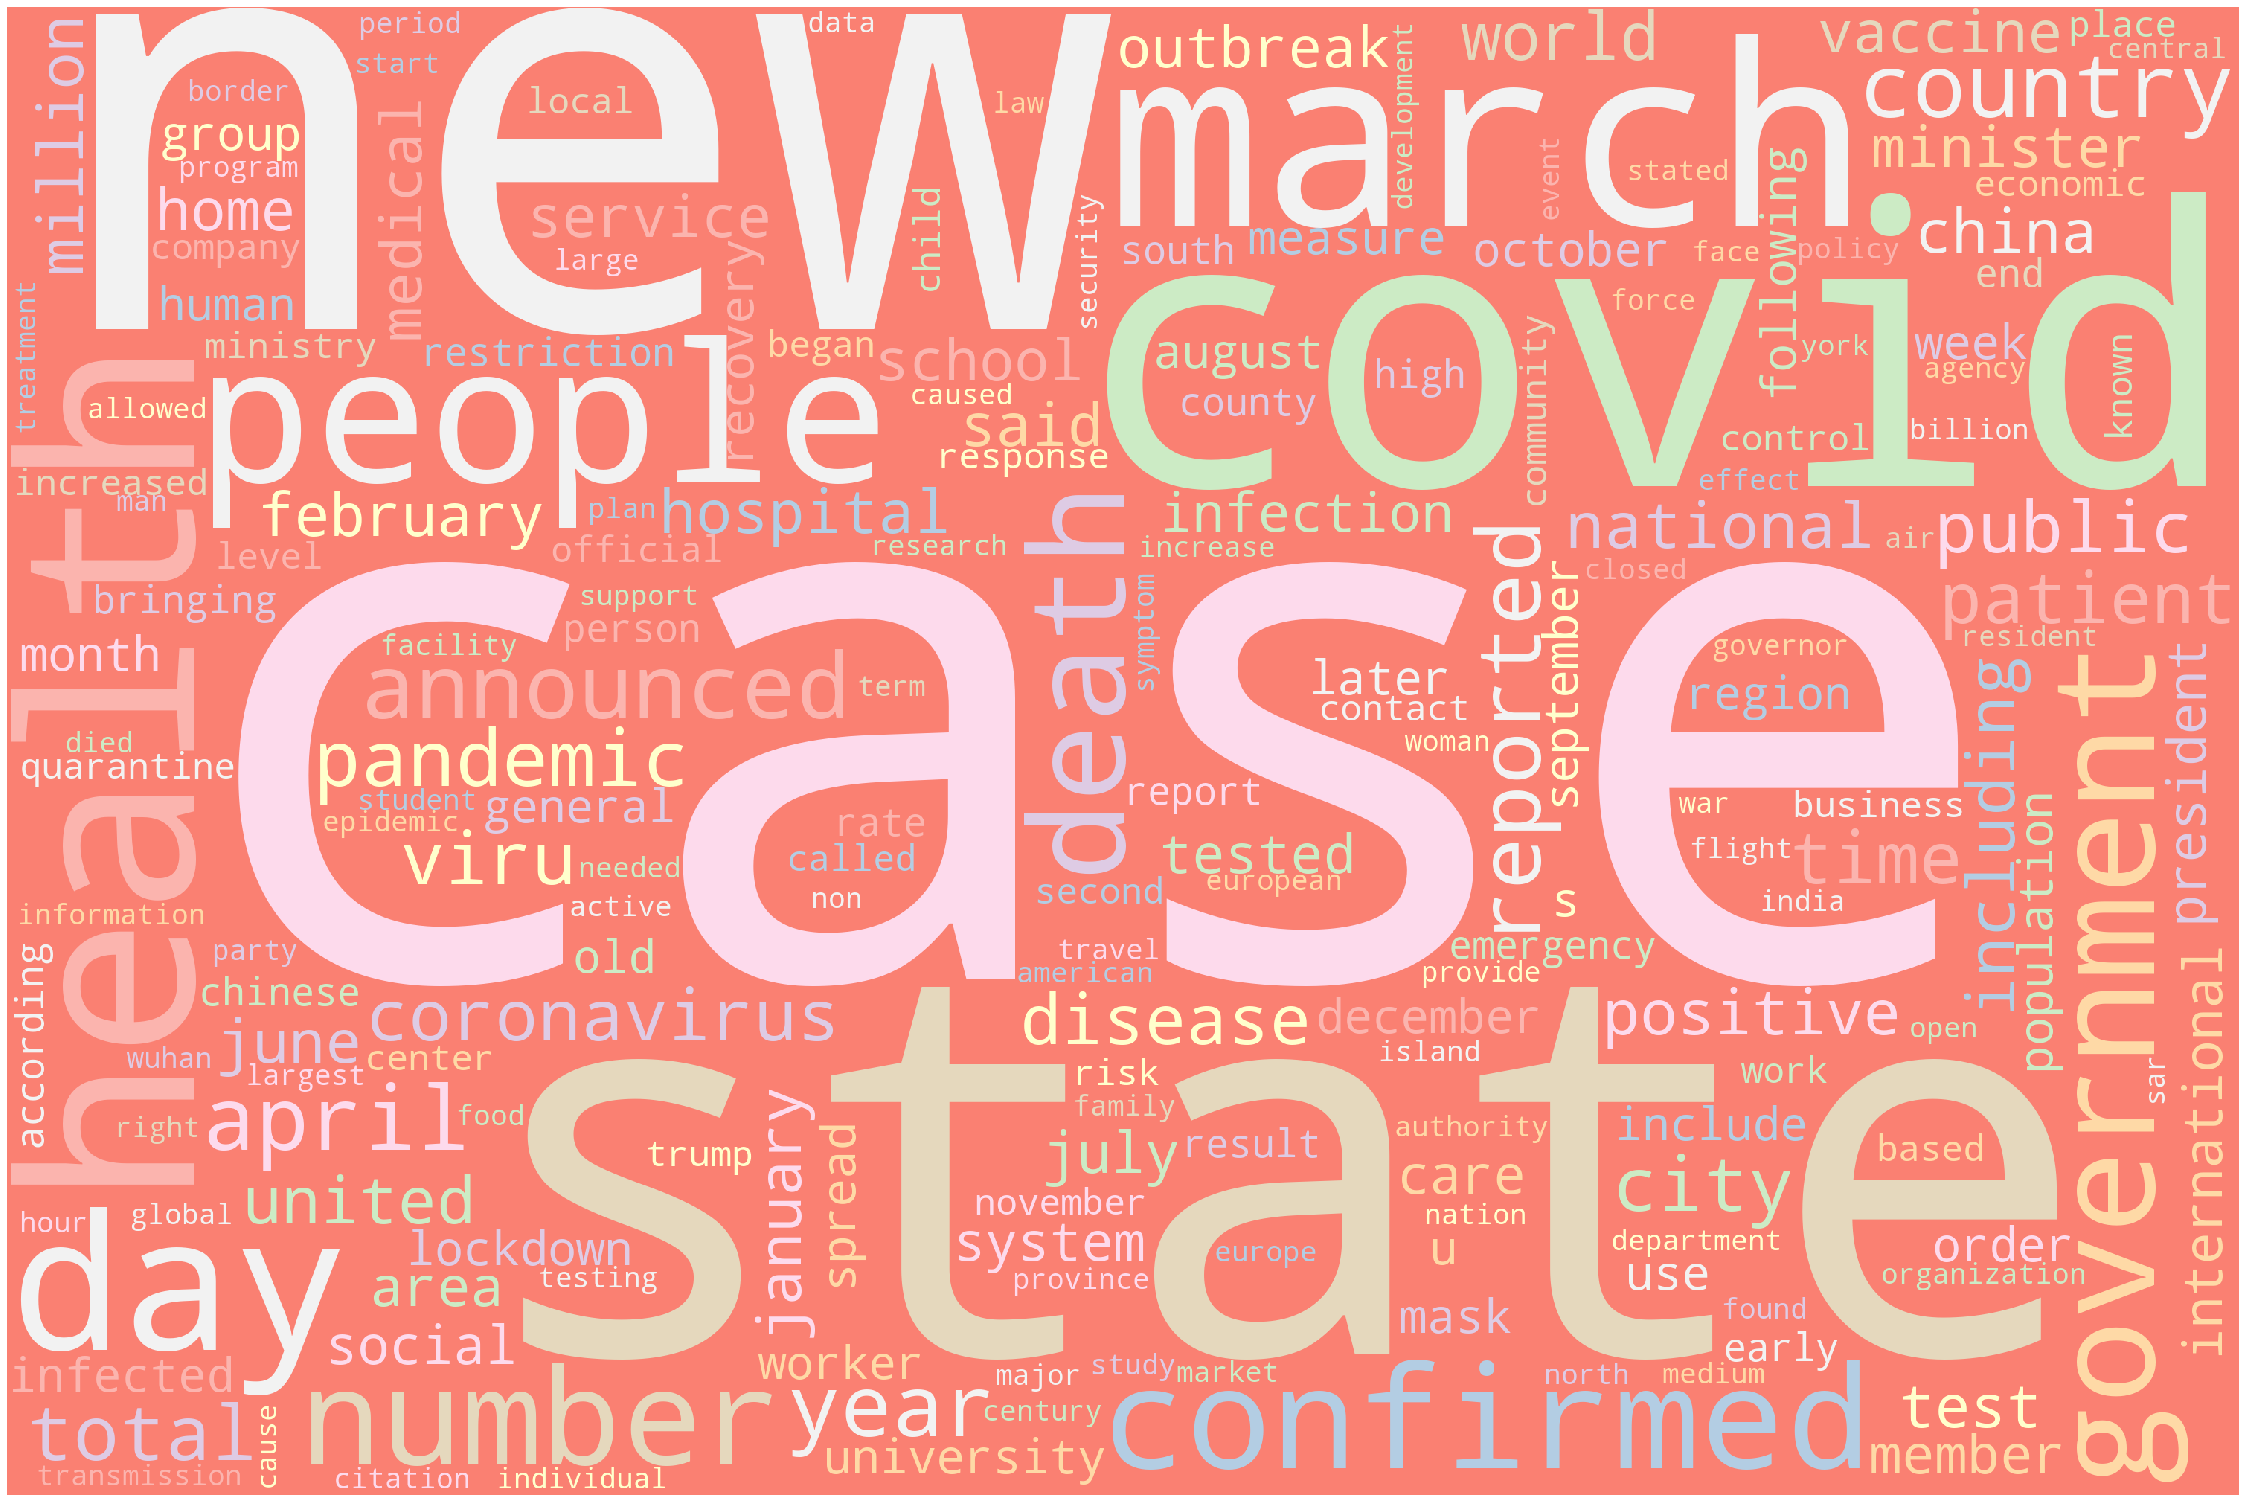

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


    
all_words_joined = ' '
word_cloud_text = all_words_joined.join(all_words)


wordcloud = WordCloud(width = 3000, height = 2000, random_state=1,
                      background_color='salmon', colormap='Pastel1',
                      collocations=False).generate(word_cloud_text)


plt.figure(figsize=(40, 30))
plt.imshow(wordcloud) 
plt.axis("off")

The word cloud definitely indicates that the text is all about covid. I think that seems pretty self-explanatory, so I'm not sure what else to say :|

## 5.2a

In [8]:
#Some additional tweet preprocessing to remove punctuation, links, and stopwords

test_tweets = nltk.flatten(pickle.load(open("test_tweets.p", "rb")))
# print(len(nltk.flatten(test_tweets)))

sp = spacy.load("en_core_web_sm")
all_stopwords = sp.Defaults.stop_words

test_tweets_words = []

punct_list = []

for punct in string.punctuation:
    punct_list.append(punct)

punct_list += ['``', "''", 'https']

for word in test_tweets:
    if word in punct_list or word[0] == '/' or word in all_stopwords:
        continue
    else:
        test_tweets_words.append(word)

test_tweet_counts = Counter(test_tweets_words)

In [9]:
num_oov_wt = 0
for word in test_tweet_counts.keys():
    if word not in wiki_word_count.keys():
        num_oov_wt += 1

print("The number of OOV word types is: ", num_oov_wt)
print("The number of word types in my test tweets is: ", len(test_tweet_counts.keys()))
print("The OOV rate is: ", num_oov_wt/len(test_tweet_counts.keys()))
        

The number of OOV word types is:  478
The number of word types in my test tweets is:  2517
The OOV rate is:  0.18990862137465236


## 5.2b

In [10]:
num_oov_tokens = 0

total_tokens = 0

for key in test_tweet_counts.keys():
    total_tokens += test_tweet_counts[key]
    

for word in test_tweet_counts.keys():
    if word not in wiki_word_count.keys():
#         print(word)
        num_oov_tokens += test_tweet_counts[word]

print("The number of OOV tokens is: ", num_oov_tokens)
print("The number of tokens in my test tweets is: ", total_tokens)
print("The OOV rate is: ", num_oov_tokens/total_tokens)   

The number of OOV tokens is:  699
The number of tokens in my test tweets is:  7105
The OOV rate is:  0.09838142153413089


## 5.2c

In [11]:
#Some additional tweet preprocessing to remove punctuation, links, and stopwords

train_tweets = nltk.flatten(pickle.load(open("train_tweets.p", "rb")))

sp = spacy.load("en_core_web_sm")
all_stopwords = sp.Defaults.stop_words

train_tweets_words = []

punct_list = []

for punct in string.punctuation:
    punct_list.append(punct)

punct_list += ['``', "''", 'https']

for word in train_tweets:
    if word in punct_list or word[0] == '/' or word in all_stopwords:
        continue
    else:
        train_tweets_words.append(word)

# print(len(train_tweets_words))
train_tweet_counts = Counter(train_tweets_words)

In [12]:
num_oov_tokens = 0
total_tokens = 0

for key in train_tweet_counts.keys():
    total_tokens += train_tweet_counts[key]
    

for word in train_tweet_counts.keys():
    if word not in wiki_word_count.keys():
#         print(word)
        num_oov_tokens += test_tweet_counts[word]

print("The number of OOV tokens is: ", num_oov_tokens)
print("The number of tokens in my train tweets is: ", total_tokens)
print("The OOV rate is: ", num_oov_tokens/total_tokens)  

The number of OOV tokens is:  698
The number of tokens in my train tweets is:  67994
The OOV rate is:  0.010265611671618083


## 5.2d

Most of the words that are oov are words in a hashtag that weren't split up by the preprocessing like "whcovidresponse", emojis, or mis-spellings. It indicates that the language used on Wikipedia is much more formal than that of Twitter despite them both being on the same topic.

When you include more data using the train tweet set, the OOV rate goes down because there are more words in the vocabulary with a larger set of tweets.

## 5.3a

In [13]:
links = get_links(url)
links.insert(0, url)

sent_9000 = []

idx = 0

while len(sent_9000) < 9000:
    text = get_article_text(links[idx])
    sent_text = nltk.tokenize.sent_tokenize(text)
    for sent in sent_text:
        sent_9000.append(sent)
    idx += 1

In [14]:
def preprocess_wiki(text):
    
    punct_list = []
    for punct in string.punctuation:
        punct_list.append(punct)

    punct_list += ['``', "''", 'https']
    
    clean_text = []
    for sent in text:
        sent = sent.lower()
        token_sent = nltk.tokenize.word_tokenize(sent)
        clean_token_sent = []
        for word in token_sent:
            if word in punct_list:
                continue
            else:
                clean_token_sent.append(word)
        clean_text.append(clean_token_sent)
        
    return clean_text

clean_text = preprocess_wiki(sent_9000)



In [15]:
# Some additional tweet preprocessing to remove punctuation, links, and stopwords in order to
# make the two sets look the same

def get_clean_test_tweets():
    test_tweets = pickle.load(open("test_tweets.p", "rb"))
    # print(test_tweets[1])

    clean_test_tweets = []

    punct_list = []

    for punct in string.punctuation:
        punct_list.append(punct)

    punct_list += ['``', "''", 'https']

    for sent in test_tweets:
        clean_sent = ''
        for word in sent:
            if word in punct_list or word[0] == '/':
                continue
            else:
                clean_sent += word + ' '
        clean_test_tweets.append(clean_sent)
    return clean_test_tweets



In [17]:
trigrams, trigram_vocab = padded_everygram_pipeline(3, clean_text)
trigram_model = KneserNeyInterpolated(3)
trigram_model.fit(trigrams, trigram_vocab)

In [ ]:
clean_test_tweets = get_clean_test_tweets()

perplexities = []

clean_test_tweets, _ = padded_everygram_pipeline(3, clean_test_tweets)

for i, gram in enumerate(clean_test_tweets):
    try:
        perplexity = trigram_model.perplexity(gram)
        perplexities.append(perplexity)
        
    except:
        continue

this is what covid took from us 
52430.908419617794
47140.98769004208
40937.68299179382
734.2989157333084
67662.29476480835
58555.68497172129
734.2989157333084
61668.334012169966
60368.53696986148
56046.898332639634
59642.984473904544
71948.582794732
48288.27275979694
54460.76355057665
734.2989157333084
60149.31171283536
61191.48315416101
59238.211418812614
46479.74366972315
58529.36008033375
734.2989157333084
55873.59977249937
60988.03419385825
734.2989157333084
41008.61938119586
66116.34519950202


In [19]:
perplexities = pickle.load(open("perplexities_5-3.p", "rb"))

avg_p = 0

for p in perplexities:
    avg_p += p
avg_p = avg_p/len(perplexities)

print("The average perplexity for the test tweets is ", avg_p)

The average perplexity for the test tweets is  46603.46743001163


## 5.3b

The super high perplexity here seems to indicate that the language used in twitter differs a lot from wikipedia language as the perplexity in problem 4.1 was only around 1100